In [1]:
%pylab inline
plt.style.use("bmh")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams["figure.figsize"] = (6,6)

In [3]:
import numpy as np
import pandas as pd

In [4]:
import tqdm
import pathlib

In [80]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor


In [6]:
DATA_DIR = pathlib.Path("./csv")

In [7]:
RS = 283654

### Версии:

- `numpy`: 1.16.3
- `pandas`: 0.24.2
- `sklearn`: 0.21.2

# Загрузка данных

In [8]:
train_target = pd.read_csv(DATA_DIR.joinpath("rubber_target_train.csv"), index_col="date", parse_dates=["date"])
test_target = pd.read_csv(DATA_DIR.joinpath("rubber_test_timestamps.csv"), index_col="date", parse_dates=["date"])
data = pd.read_csv(DATA_DIR.joinpath("rubber_daily.csv"), index_col="date", parse_dates=["date"])

In [9]:
train_target.head()

,rubber
date,
2002-08-01,830.595238
2002-09-01,895.476190
2002-10-01,831.304348
2002-11-01,840.250000
2002-12-01,849.875000


In [10]:
data.head()

,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,USDTHB_mid,USDTHB_max,...,USDTHB_open,USDIDR_mid,USDIDR_max,USDIDR_min,USDIDR_open,USDVND_mid,USDVND_max,USDVND_min,USDVND_open,rubber_close
date,,,,,,,,,,,,,,,,,,,,,
2002-07-01,25.64,25.50,25.72,25.39,8.2770,8.2770,8.2770,8.2770,41.570,41.570,...,41.50,8710.0,8715.0,8669.0,8700.0,15297.5,NaN,NaN,NaN,835.0
2002-07-02,25.75,25.61,25.97,25.60,8.2769,8.2769,8.2769,8.2769,41.515,41.560,...,41.54,8805.0,8820.0,8720.0,8720.0,15297.0,NaN,NaN,NaN,827.5
2002-07-03,25.84,25.73,25.96,25.52,8.2768,8.2768,8.2768,8.2768,41.610,41.645,...,41.53,8965.0,8985.0,8790.0,8825.0,15297.5,NaN,NaN,NaN,847.5
2002-07-04,25.55,25.88,25.94,25.50,8.2767,8.2767,8.2767,8.2767,41.545,41.620,...,41.50,8855.0,8970.0,8790.0,8790.0,15298.5,NaN,NaN,NaN,847.5
2002-07-05,25.73,25.65,25.75,25.42,8.2766,8.2766,8.2766,8.2766,41.645,41.640,...,41.56,8860.0,8850.0,8815.0,8830.0,15295.0,NaN,NaN,NaN,847.5


In [11]:
test_target.head()

""
date
2016-01-01
2016-02-01
2016-03-01
2016-04-01
2016-05-01


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4221 entries, 2002-07-01 to 2019-06-28
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brent_close   4221 non-null   float64
 1   brent_open    4221 non-null   float64
 2   brent_max     4221 non-null   float64
 3   brent_min     4221 non-null   float64
 4   USDCNY_close  4221 non-null   float64
 5   USDCNY_open   4221 non-null   float64
 6   USDCNY_max    4221 non-null   float64
 7   USDCNY_min    4221 non-null   float64
 8   USDTHB_mid    4221 non-null   float64
 9   USDTHB_max    4220 non-null   float64
 10  USDTHB_min    4220 non-null   float64
 11  USDTHB_open   4220 non-null   float64
 12  USDIDR_mid    4219 non-null   float64
 13  USDIDR_max    4092 non-null   float64
 14  USDIDR_min    4092 non-null   float64
 15  USDIDR_open   4091 non-null   float64
 16  USDVND_mid    4209 non-null   float64
 17  USDVND_max    2675 non-null   float64
 18  USDVND_min

Text(0.5, 1.0, 'Rubber prices')

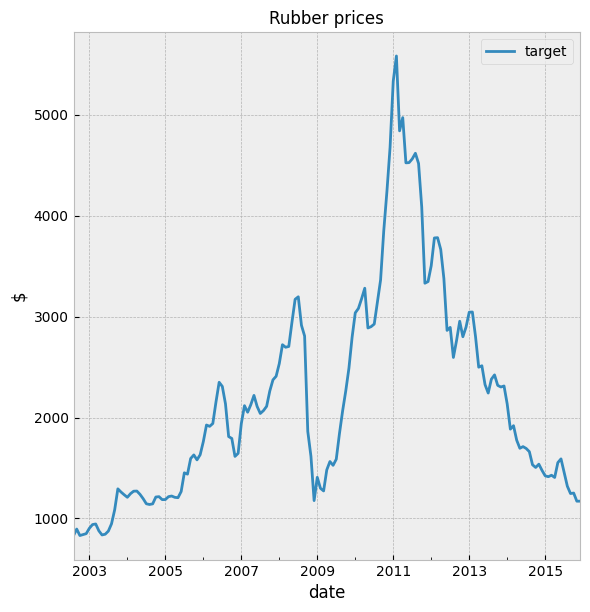

In [13]:
train_target["rubber"].plot(ax=plt.gca(), label="target")
plt.legend(loc=0)
plt.ylabel("$")
plt.tight_layout()
plt.title("Rubber prices", fontsize=12)

# Признаки

In [14]:
fts = data.resample("D").mean()

In [15]:
PERIODS = ["1D", "7D", "30D", "60D", "180D"]
AGGREGATES = ["mean", "median", "std", "max", "min"]

In [16]:
all_features = []

for period in tqdm.tqdm_notebook(PERIODS):
    for agg in AGGREGATES:
        if agg != "mean" and period == "1D":
            continue
        rolling_features = fts.rolling(period).aggregate(agg)
        rolling_features.rename(lambda x: "_".join([x, period, agg]), axis=1, inplace=True)
        all_features.append(rolling_features[rolling_features.index.day==9])

C:\Users\user\AppData\Local\Temp\ipykernel_17628\81040520.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for period in tqdm.tqdm_notebook(PERIODS):


  0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
all_features = pd.concat(all_features, axis=1)

In [18]:
all_features.head()

,brent_close_1D_mean,brent_open_1D_mean,brent_max_1D_mean,brent_min_1D_mean,USDCNY_close_1D_mean,USDCNY_open_1D_mean,USDCNY_max_1D_mean,USDCNY_min_1D_mean,USDTHB_mid_1D_mean,USDTHB_max_1D_mean,...,USDTHB_open_180D_min,USDIDR_mid_180D_min,USDIDR_max_180D_min,USDIDR_min_180D_min,USDIDR_open_180D_min,USDVND_mid_180D_min,USDVND_max_180D_min,USDVND_min_180D_min,USDVND_open_180D_min,rubber_close_180D_min
date,,,,,,,,,,,,,,,,,,,,,
2002-07-09,25.17,25.10,25.20,24.75,8.2766,8.2766,8.2766,8.2766,41.265,41.45,...,41.42,8710.0,8715.0,8669.0,8700.0,15295.0,NaN,NaN,NaN,827.5
2002-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,NaN,NaN,NaN,772.5
2002-09-09,28.49,28.61,28.65,28.05,8.2770,8.2770,8.2770,8.2770,42.405,42.42,...,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,NaN,NaN,NaN,772.5
2002-10-09,28.13,28.09,28.40,27.87,8.2771,8.2771,8.2771,8.2771,43.680,43.75,...,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,NaN,NaN,NaN,772.5
2002-11-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,NaN,NaN,NaN,772.5


Выравниваем признаки к таргету:

In [19]:
all_features["prediction_date"] = (all_features.index
                                   + pd.TimedeltaIndex(all_features.index.days_in_month-8,
                                                       unit="D"))

Исключаем признаки, в которых слишком много `NaN`:

In [20]:
COLS = [col for col in all_features if ("USDVND_max" not in col
                                        and "USDVND_min" not in col
                                        and "USDVND_open" not in col)]
final_fts = all_features[COLS].ffill()

Формируем финальный датафрейм:

In [21]:
df = train_target.join(final_fts.set_index("prediction_date"), how="outer")
df.index.name = "date"
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 2002-08-01 to 2019-07-01
Columns: 379 entries, rubber to rubber_close_180D_min
dtypes: float64(379)
memory usage: 605.6 KB


Добавляем календарные признаки:

In [33]:
df["month"] = df.index.month
df1 = df[:'2015'].copy()
FTS_COLS = df1.columns[1:]
TARGET = "rubber"
df1.isnull().sum().sum()

0

In [103]:
need = df["2016":].copy()

In [34]:
df1

,rubber,brent_close_1D_mean,brent_open_1D_mean,brent_max_1D_mean,brent_min_1D_mean,USDCNY_close_1D_mean,USDCNY_open_1D_mean,USDCNY_max_1D_mean,USDCNY_min_1D_mean,USDTHB_mid_1D_mean,...,USDTHB_max_180D_min,USDTHB_min_180D_min,USDTHB_open_180D_min,USDIDR_mid_180D_min,USDIDR_max_180D_min,USDIDR_min_180D_min,USDIDR_open_180D_min,USDVND_mid_180D_min,rubber_close_180D_min,month
date,,,,,,,,,,,,,,,,,,,,,
2002-08-01,830.595238,25.17,25.10,25.20,24.75,8.2766,8.2766,8.2766,8.2766,41.265,...,41.45,41.210,41.42,8710.0,8715.0,8669.0,8700.0,15295.0,827.5,8
2002-09-01,895.476190,25.17,25.10,25.20,24.75,8.2766,8.2766,8.2766,8.2766,41.265,...,40.45,40.195,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,772.5,9
2002-10-01,831.304348,28.49,28.61,28.65,28.05,8.2770,8.2770,8.2770,8.2770,42.405,...,40.45,40.195,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,772.5,10
2002-11-01,840.250000,28.13,28.09,28.40,27.87,8.2771,8.2771,8.2771,8.2771,43.680,...,40.45,40.195,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,772.5,11
2002-12-01,849.875000,28.13,28.09,28.40,27.87,8.2771,8.2771,8.2771,8.2771,43.680,...,40.45,40.195,40.39,8710.0,8715.0,8669.0,8700.0,15292.0,772.5,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-01,1319.947368,58.61,57.10,59.27,57.01,6.2088,6.2100,6.2100,6.2069,33.940,...,32.38,32.260,32.28,12472.5,12505.0,12400.0,12400.0,21165.0,1380.0,8
2015-09-01,1247.200000,58.61,57.10,59.27,57.01,6.2088,6.2100,6.2100,6.2069,33.940,...,32.38,32.260,32.28,12715.0,12715.0,12675.0,12675.0,21287.5,1367.0,9
2015-10-01,1252.136364,47.58,49.39,50.04,47.32,6.3778,6.3610,6.3800,6.3610,36.200,...,32.42,32.260,32.28,12850.0,12870.0,12800.0,12833.0,21475.0,1219.0,10


# Модели

**Построим LassoCV, ExtraTreesRegressor, Ridge, RandomForestRegressor**

In [64]:
X = df1[FTS_COLS]
y = df1[TARGET]

In [65]:
#X, y

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.3, random_state=42, shuffle = True)

In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [81]:
extratrees = ExtraTreesRegressor(n_estimators=150, random_state=42).fit(X_train, Y_train)
lasso = LassoCV(random_state=42).fit(X_train, Y_train)
linreg = LinearRegression().fit(X_train, Y_train)
ridge_cv = RidgeCV().fit(X_train, Y_train)
random_forest = RandomForestRegressor(n_estimators=64).fit(X_train, Y_train)

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.238e+04, tolerance: 8.626e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.342e+04, tolerance: 8.626e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

**Посмотрим у какой модели наибольший score**

In [96]:
print(extratrees.score(X_test, Y_test),
     lasso.score(X_test, Y_test),
     linreg.score(X_test, Y_test),
     ridge_cv.score(X_test, Y_test),
     random_forest.score(X_test, Y_test))

0.9745863340603234 0.9395214541915632 -0.21210355779695655 -0.09329039297827446 0.9616559231476716


**Наибольший у extratreesregressor, хотя RandomForest тоже близок по значению**

**Выведем предсказанные значения нашей модели**

In [104]:
predictions = pd.DataFrame(extratrees.predict(need[FTS_COLS]), columns=["rubber"], index=target.index)
predictions.loc[test_target.index].to_csv("rubber_extra_trees_regressor.csv")
print(target_preds.loc[test_target.index])

                 rubber
date                   
2016-01-01  1213.760320
2016-02-01  1207.470713
2016-03-01  1228.565506
2016-04-01  1213.337865
2016-05-01  1267.429393
2016-06-01  1313.216239
2016-07-01  1233.947156
2016-08-01  1233.627216
2016-09-01  1256.963853
2016-10-01  1253.928142
2016-11-01  1296.942187
2016-12-01  1337.928812
2017-01-01  1456.550541
2017-02-01  1925.976456
2017-03-01  2120.515842
2017-04-01  2102.159633
2017-05-01  1553.722493
2017-06-01  1337.648231
2017-07-01  1292.864284
2017-08-01  1299.146434
2017-09-01  1333.417637
2017-10-01  1409.736423
2017-11-01  1409.695898
2017-12-01  1462.657223
2018-01-01  1473.208019
2018-02-01  1486.334006
2018-03-01  1486.663378
2018-04-01  1490.618073
2018-05-01  1445.789368
2018-06-01  1500.495151
2018-07-01  1484.297616
2018-08-01  1461.434540
2018-09-01  1408.371110
2018-10-01  1406.782801
2018-11-01  1427.262026
2018-12-01  1411.079891
2019-01-01  1390.716961
2019-02-01  1414.198939
2019-03-01  1451.742846
2019-04-01  1514